Manuel Agraz Vallejo
# AI534 IA2 - Logistic regression with L2 and L1 regularization

**Submission**:  
1. Your completed notebook in ipynb
2. a PDF report that includes all code outputs and figures. You can use the code block at the end of the notebook to generate a PDF export of the notebook with the outputs for your report. However, if any figures or outputs are missing, you must either:


* Manually add the missing figures to the PDF using a PDF editor or
* Copy your notebook contents into a Word or Google Doc, insert the missing outputs there, and export that document as a PDF.


**Overview.** In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [1]:
# !pip install nbconvert > /dev/null 2>&1
# !pip install pdfkit > /dev/null 2>&1
# !apt-get install -y wkhtmltopdf > /dev/null 2>&1
# from google.colab import files

import os
import pdfkit
import contextlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# add more imports if necessary

# Part 0. (2 pts) Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for Part 3). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
# noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

#My local paths
train_path = './IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = './IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = './IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

 ## 🚧 Preprocessing.
 You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [3]:
# your code goes here
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
noisy_train_df = pd.read_csv(noisy_train_path)


def preprocess(train_df, df):

    train_df = train_df.copy()
    df = df.copy()

    #Normalize all columns except price
    for col_name in ["Age", "Annual_Premium", "Vintage"]:
        mu = train_df[col_name].mean()
        sigma =train_df[col_name].std()
        
        df[col_name] = (df[col_name] - mu) / sigma
    
    # Add bias column
    bias = pd.Series(0.0, index=df.index, name='bias')
    df = pd.concat([bias, df], axis=1)

    return df.drop(columns=['Response']), df['Response']

x_train, y_train = preprocess(train_df, train_df)
x_val, y_val = preprocess(train_df, val_df)
x_noisy_train, y_noisy_train = preprocess(noisy_train_df, noisy_train_df)

# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information on canvas).


##  🚧  Impelement Logistic regression with L2 regularization
Your implemented function should take the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector and the sequence of training losses, which will allow you to visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [4]:
# your code goes here
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ridge_logistic_gradient_descent(x, y, gamma, lmbda, epochs, epsilon_loss=None, epsilon_grad=None):
    y=np.expand_dims(y, axis=-1)

    N,d = x.shape
    w = np.random.normal(0, 0.01, (d,1))
    losses = []

    for epoch in range(epochs):

        #Compute prediction
        y_pred = x @ w

        #Calculate loss
        sigma = sigmoid(y_pred)
        
        logistic_term = -np.mean(y * np.log(sigma) + (1 - y) * np.log(1 - sigma))
        reg_term = (lmbda/2) * np.sum(w[1:]**2) #Exclude bias from regularization

        ridge_loss = logistic_term + reg_term

        # DIVERGENCE DETECTION
        if np.isnan(ridge_loss) or np.isinf(ridge_loss):
            print(f"DIVERGENCE DETECTED at epoch {epoch}!")
            print(f"Loss became {'NaN' if np.isnan(ridge_loss) else 'Inf'}")
            return w, losses
        
        if len(losses) > 0 and ridge_loss > 10 * losses[0]:
            print(f"DIVERGENCE DETECTED at epoch {epoch}!")
            print(f"Loss exploded: {ridge_loss:.4f} >> initial loss {losses[0]:.4f}")
            return w, losses

        #Calculate gradient of the loss
        gradient_logistic = (1/N) * x.T @ (sigma-y)

        gradient_reg = lmbda * w
        gradient_reg[0] = 0 #Do not regularize bias

        gradient_ridge = gradient_logistic + gradient_reg

        #Perform gradient descent update
        w -= gamma * gradient_ridge 

        #Store loss
        losses.append(ridge_loss)

        if epsilon_loss is not None and epoch > 0:
            if abs(losses[-1] - losses[-2]) < epsilon_loss:
                print(f"Converged at epoch {epoch}")
                break
        
        if epsilon_grad is not None:
            if np.linalg.norm(gradient_ridge) < epsilon_grad:
                print(f"Gradient converged at epoch {epoch}")
                break
    
    return w, losses

# weights, losses = ridge_logistic_gradient_descent(x_train.to_numpy(), y_train.to_numpy(), gamma=0.01, lmbda=0.1, epochs=5000, epsilon_loss=10e-7)

# print(weights.shape)
# print(weights)

## 🚧 Experiment with different regularization parameters
For this part, you will run your L2 logistic regression on the training data with different regularization strengths $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required for your exploration. You are encouraged to try additional intermediate or more extreme values if it helps you better analyze the results and answer the questions.

**Learning Rate Tuning Guidelines:**
The learning rate value ($\gamma$)  will need to be adjusted depending on the value of $\lambda$:
*   For very small $\lambda$ values (e.g.,$10^{-5}, 10^{-4}$), start with a  larger learning rate (e.g., $\gamma=1$) .
*   For moderate $\lambda$ values like $10^{-3}$, try a smaller learning rate like $\gamma = 0.1$.
*   As $\lambda$ increases further, continue decreasig the learning rate to maintain stable convergence.

** Why smaller learning rate for larger $\lambda$?**
Stronger regularization amplifies the contribution of the penalty term in the gradient. Using the same learning rate across all $\lambda$ values can lead to overly large update steps and unstable training. Adjusting the learning rate ensures smoother and more stable convergence.


**What to complete here.**
For each $\lambda$ value:

* Run your logistic regression until it converges(using your early stopping critierion).
* Record the final weight vector, which will be used later.
* Compute and record the training and validation accuracies
* Summarize your results in a clear table that lists each $\lambda$ value, the corresponding training accuracy, and validation accuracy. You will use this data in the next part to create your plots.

Learning rate: 0.001,   Regularization rate: 1
Converged at epoch 1850
Learning rate: 0.01,   Regularization rate: 0.1
Converged at epoch 1623
Learning rate: 0.1,   Regularization rate: 0.01
Converged at epoch 906
Learning rate: 0.1,   Regularization rate: 0.001
Converged at epoch 2613
Learning rate: 0.8,   Regularization rate: 0.0001
Converged at epoch 1625
Learning rate: 0.9,   Regularization rate: 1e-05
Converged at epoch 1870

RESULTS SUMMARY
 lambda  train_acc  val_acc  final_train_loss  converge_epoch
1.00000   0.730833   0.7356          0.668061            1851
0.10000   0.777667   0.7790          0.582208            1624
0.01000   0.786500   0.7854          0.480147             907
0.00100   0.795000   0.7935          0.437307            2614
0.00010   0.800500   0.7936          0.424812            1626
0.00001   0.801667   0.7940          0.422848            1871


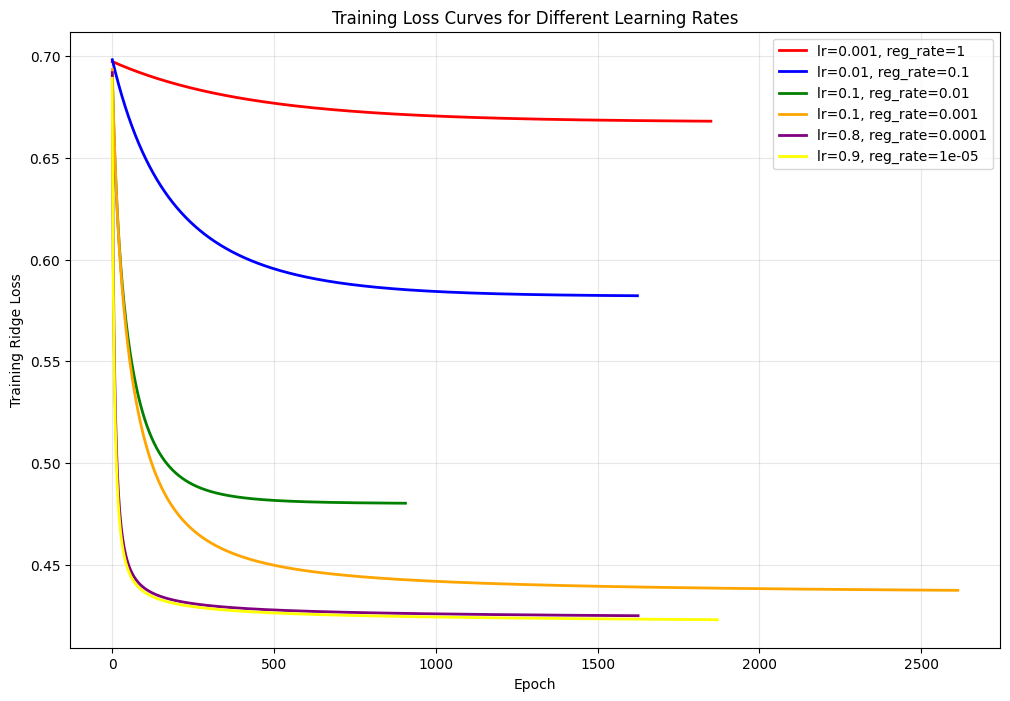

In [5]:
# Your code goes here
# Set random seed for reproducibility
np.random.seed(42)

reg_rates = [10**-i for i in range(0,6)]
learning_rates = [1e-3, 1e-2, 1e-1, 1e-1, 0.8, 0.9]

results = []


w_list = []
train_losses_list = []
converged_rates = []

for i, (reg_rate, lr) in enumerate(zip(reg_rates, learning_rates)):
    print(f"Learning rate: {lr},   Regularization rate: {reg_rate}")
    
    w, losses = ridge_logistic_gradient_descent(x_train.to_numpy(), y_train.to_numpy(), gamma=lr, lmbda=reg_rate, epochs=5000, epsilon_loss=10e-7)
    
    # Check if converged (no NaN values)
    if not np.any(np.isnan(w)) and not np.any(np.isnan(losses)):
        w_list.append(w)
        train_losses_list.append(losses)
        converged_rates.append((reg_rate,lr))

        # Calculate training accuracy
        y_train_pred = sigmoid(x_train.to_numpy() @ w)
        y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
        train_accuracy = np.mean(y_train_pred_binary.flatten() == y_train.to_numpy())
        
        # Calculate validation accuracy
        y_val_pred = sigmoid(x_val.to_numpy() @ w)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        val_accuracy = np.mean(y_val_pred_binary.flatten() == y_val.to_numpy())

        # Store results
        results.append({
            'lambda': reg_rate,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'final_train_loss': losses[-1],
            'converge_epoch': len(losses)
        })

# Create and display results table
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

#Plot learning curves
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

for i, (rates, losses) in enumerate(zip(converged_rates, train_losses_list)):
    plt.plot(losses, color=colors[i % len(colors)], label=f'lr={rates[1]}, reg_rate={rates[0]}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training Ridge Loss')
plt.title('Training Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 🚧 Visualize and analyze $\lambda$'s impact on training and validation accuracy

Now, use the results from your experiments to visualize how model performance changes with the regularization strength. Plot both the training accuracy and validation accuracy of your L2 regularized logistic regression model as a function of $\lambda$.
* Use a logarithmic scale for the x-axis to represent $\lambda$. Each tick mark on the x-axis should correspond to an integar $i$ and be labeled as $10^{i}$. This helps you clearly see performance trends across multiple orders of magnitude of $\lambda$.  

* Plot the two curves in the same figure, one for training accuracy and one for validation accuracy, using different colors for clarity.
* Include a legend to indicate which curve corresponds to which accuracy measure, and label the axis clearly.

Your final plot should make it easy to compare how regularization affects training vs. validation performance.

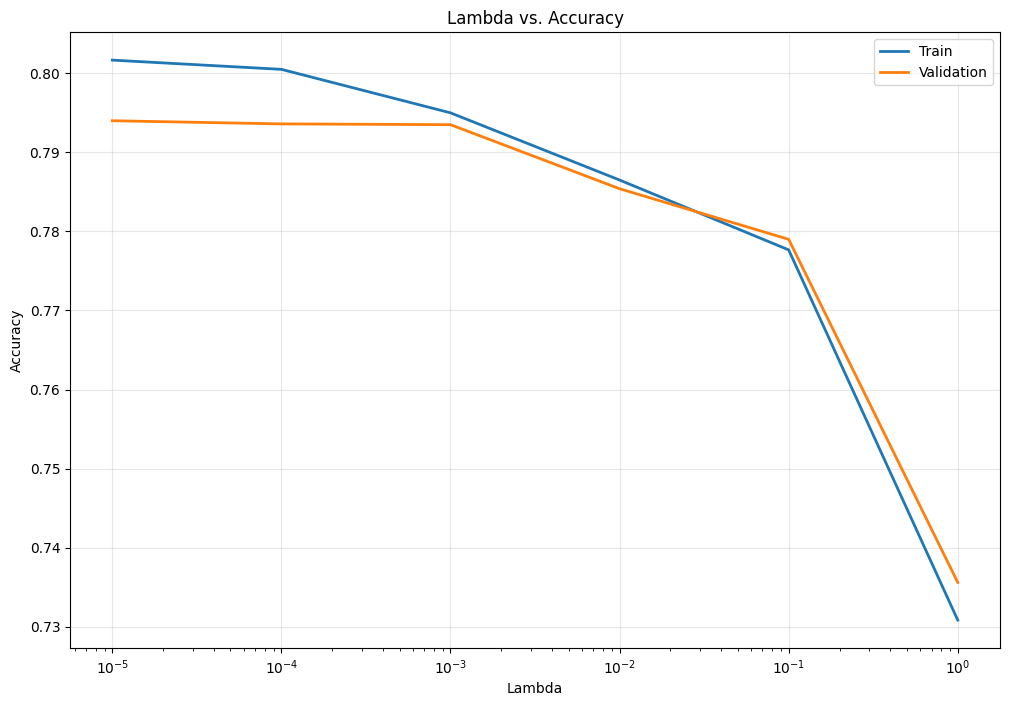

In [6]:
# Your code goes here
#Plot learning curves
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

train_acc = results_df['train_acc'].to_numpy()
val_acc = results_df['val_acc'].to_numpy()

reg_rates_arr = np.array(reg_rates)

plt.plot(reg_rates_arr, train_acc, label='Train', linewidth=2)

plt.plot(reg_rates_arr, val_acc, label='Validation', linewidth=2)

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Lambda vs. Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ✍️ Question

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?


(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.




a) **A small value of 10e-5 leads to both the best training and validation accuracy. I would pick the model with a small regularization rate.**

b) **I observed that small amounts of regularization are beneficial as they lead to the highest accuracies on both test and train data. However as regularization increases we see a steep decline in accuracy in both test and train set. This is occuring because we are not letting the model achieve the weights necessary for good performance as we are punishing any increase in their magnitudes.**


## 🚧  Examine the impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [7]:
#Your code goes here
reg_rate_feature_map = {}

# Get feature names (excluding bias)
feature_names = x_train.columns[1:].tolist()  # Skip bias column

for w, reg_rate in zip(w_list, reg_rates):
    # Get weights excluding bias (first element)
    weights_no_bias = w[1:].flatten()
    
    # Get absolute values for ranking
    abs_weights = np.abs(weights_no_bias)
    
    # Get indices of top 5 features by weight magnitude
    top_indices = np.argsort(abs_weights)[::-1][:5]
    
    # Create list of (feature_name, weight) tuples for top 5
    top_features = []
    for idx in top_indices:
        feature_name = feature_names[idx]
        weight_value = weights_no_bias[idx]
        top_features.append(f"{feature_name}, {weight_value:.4f}")
    
    # Store in dictionary
    reg_rate_feature_map[f"λ = {reg_rate}"] = top_features

# Split into three tables (2 columns each)
lambda_cols = list(reg_rate_feature_map.keys())
n_cols_per_table = 2

# Create first table (first 2 lambda values)
first_cols = lambda_cols[:n_cols_per_table]
reg_rate_feature_df1 = pd.DataFrame({col: reg_rate_feature_map[col] for col in first_cols})
reg_rate_feature_df1.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df1) + 1))

# Create second table (next 2 lambda values)
second_cols = lambda_cols[n_cols_per_table:2*n_cols_per_table]
reg_rate_feature_df2 = pd.DataFrame({col: reg_rate_feature_map[col] for col in second_cols})
reg_rate_feature_df2.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df2) + 1))

# Create third table (remaining 2 lambda values)
third_cols = lambda_cols[2*n_cols_per_table:]
reg_rate_feature_df3 = pd.DataFrame({col: reg_rate_feature_map[col] for col in third_cols})
reg_rate_feature_df3.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df3) + 1))

# Display results
print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 1)")
print("="*80)
print(reg_rate_feature_df1.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 2)")
print("="*80)
print(reg_rate_feature_df2.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 3)")
print("="*80)
print(reg_rate_feature_df3.to_string(index=False))
print("="*80)
    


Feature weights ranked by regularization rates (Part 1)
 Rank                             λ = 1                           λ = 0.1
    1       Previously_Insured, -0.1015       Previously_Insured, -0.6132
    2            Vehicle_Damage, 0.0995            Vehicle_Damage, 0.5536
    3            Vehicle_Age_1, -0.0597 Policy_Sales_Channel_152, -0.2693
    4 Policy_Sales_Channel_152, -0.0575            Vehicle_Age_1, -0.2574
    5                       Age, 0.0532                    dummy, -0.1099

Feature weights ranked by regularization rates (Part 2)
 Rank                          λ = 0.01                         λ = 0.001
    1       Previously_Insured, -1.5931       Previously_Insured, -2.4693
    2            Vehicle_Damage, 1.4159            Vehicle_Damage, 2.0502
    3 Policy_Sales_Channel_152, -0.5599 Policy_Sales_Channel_160, -0.9989
    4            Vehicle_Age_1, -0.5246 Policy_Sales_Channel_152, -0.7152
    5 Policy_Sales_Channel_160, -0.3915                    dummy, -0.649

## ✍️ Question

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.

1.- **The top 2 ranked features remain the same for all lambda values. From the top-3 feature onwards the features vary among different lambdas.**

2.- **As the lambda decreses the weights of the top-5 lambdas increase. With lambda=1e-05 having the largest weights and lambda=1 having the smallest.**

3.- **As we increase lambda we increase the importance of penalizing the magnitude of the weights. This leads to smaller weights. When we loosen this penalization by decreasing the lambda, the weights are allowed to take higher values.**

## 🚧 Examine the impact on sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [8]:
# Your code goes here
sparsity_results = []

for w, reg_rate in zip(w_list, reg_rates):
    # Get weights excluding bias (first element)
    weights_no_bias = w[1:].flatten()

    # Count weights that are approximately zero (≤ 10^-6)
    sparse_count = np.sum(np.abs(weights_no_bias) <= 10e-6)
    total_features = len(weights_no_bias)

    sparsity_results.append({
        'lambda': reg_rate,
        'Sparse Features': sparse_count,
        'Total Features': total_features,
        'Sparsity Percentage': (sparse_count / total_features) * 100
    })
    
    print(f"λ = {reg_rate}: {sparse_count}/{total_features} features are sparse ({(sparse_count/total_features)*100:.1f}%)")

λ = 1: 1/197 features are sparse (0.5%)
λ = 0.1: 1/197 features are sparse (0.5%)
λ = 0.01: 0/197 features are sparse (0.0%)
λ = 0.001: 0/197 features are sparse (0.0%)
λ = 0.0001: 0/197 features are sparse (0.0%)
λ = 1e-05: 0/197 features are sparse (0.0%)


## ✍️Question

1. When we have very small $\lambda$ values (aka very weak regularization), does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


1.- **No, for the very small lambda values from 1e-5 to 1e-2 Only the two highest lambda values 1 and 0.1 lead to having weights of zero.**

2.- **As lambda is increased the sparsity of the weights increases. If we were to further increase lambda, I expect the sparsity to increase even further eventually turning all weights to zero. This happens because by increasing lambda we are penalizing the model for having large weights and so gradient descent lowers their values until they reach zero with high enough lambdas.**

# Part 2. (38 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## 🚧 Impelement Logistic regression with L1 regularization
**Requirment.**
Implement Algorithm 2 (Proximal gradient descent for LASSO logistic regression) for L1 regularized Logistic Regress, described in the IA2 reference information sheet provided on Canvas. Your implemented function should take the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector and the sequence of losses so that you can visualize the convergence process. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [9]:
# Your code goes here.
def lasso_logistic_regression(x, y, gamma, lmbda, epochs, epsilon_loss=None):
    y=np.expand_dims(y, axis=-1)

    N,d = x.shape
    w = np.random.normal(0, 0.01, (d,1))
    losses = []

    for epoch in range(epochs):

        #Compute prediction
        y_pred = x @ w

        #Calculate loss
        sigma = sigmoid(y_pred)

        # Add epsilon to prevent log(0)
        epsilon = 1e-15
        sigma = np.clip(sigma, epsilon, 1 - epsilon)
        
        logistic_term = -np.mean(y * np.log(sigma) + (1 - y) * np.log(1 - sigma))
        reg_term = lmbda * np.sum(abs(w[1:])) #Exclude bias from regularization

        lasso_loss = logistic_term + reg_term

        # DIVERGENCE DETECTION
        if np.isnan(lasso_loss) or np.isinf(lasso_loss):
            print(f"DIVERGENCE DETECTED at epoch {epoch}!")
            print(f"Loss became {'NaN' if np.isnan(lasso_loss) else 'Inf'}")
            return w, losses
        
        if len(losses) > 0 and lasso_loss > 10 * losses[0]:
            print(f"DIVERGENCE DETECTED at epoch {epoch}!")
            print(f"Loss exploded: {lasso_loss:.4f} >> initial loss {losses[0]:.4f}")
            return w, losses

        #Calculate gradient of the loss
        gradient_logistic = (1/N) * x.T @ (sigma-y)

        #Perform gradient descent update
        w_temp = w -  gamma * gradient_logistic
        w = np.sign(w_temp) * np.maximum(abs(w_temp) - gamma*lmbda, 0)

        # Don't regularize bias term (first element)
        w[0] = w_temp[0]

        #Store loss
        losses.append(lasso_loss)

        if epsilon_loss is not None and epoch > 0:
            if abs(losses[-1] - losses[-2]) < epsilon_loss:
                print(f"Converged at epoch {epoch}")
                break
    
    return w, losses

weights, losses = lasso_logistic_regression(x_train.to_numpy(), y_train.to_numpy(), gamma=0.01, lmbda=0.1, epochs=5000, epsilon_loss=10e-7)

Converged at epoch 1755


## 🚧 Experiment with different regularization parameters
For this part, you will need to apply your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are encouraged to experiment with more extreme or in-between values if it helps you in answering the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

**What to complete here.**
For each $\lambda$ value:
* Run your L1 regularized logistic regression until it converges(using your early stopping critierion).
* Record the final weight vector, which will be used later.
* Compute and record the training and validation accuracies
* Summarize your results in a clear table that lists each  λ  value, the corresponding training accuracy, and validation accuracy. You will use this data in the next part to create your plots.

Learning rate: 0.001,   Regularization rate: 0.1
Converged at epoch 2687
Learning rate: 0.01,   Regularization rate: 0.01
Learning rate: 0.1,   Regularization rate: 0.001
Converged at epoch 2368
Learning rate: 1.0,   Regularization rate: 0.0001
Converged at epoch 1230
Learning rate: 1.5,   Regularization rate: 1e-05
Converged at epoch 1532
Learning rate: 2,   Regularization rate: 1e-06
Converged at epoch 1488

RESULTS SUMMARY
  lambda  train_acc  val_acc  final_train_loss  converge_epoch
0.100000   0.743333   0.7453          0.688957            2688
0.010000   0.781000   0.7842          0.508539            5000
0.001000   0.789333   0.7903          0.443741            2369
0.000100   0.799500   0.7940          0.426872            1231
0.000010   0.801167   0.7934          0.422611            1533
0.000001   0.801667   0.7927          0.421738            1489


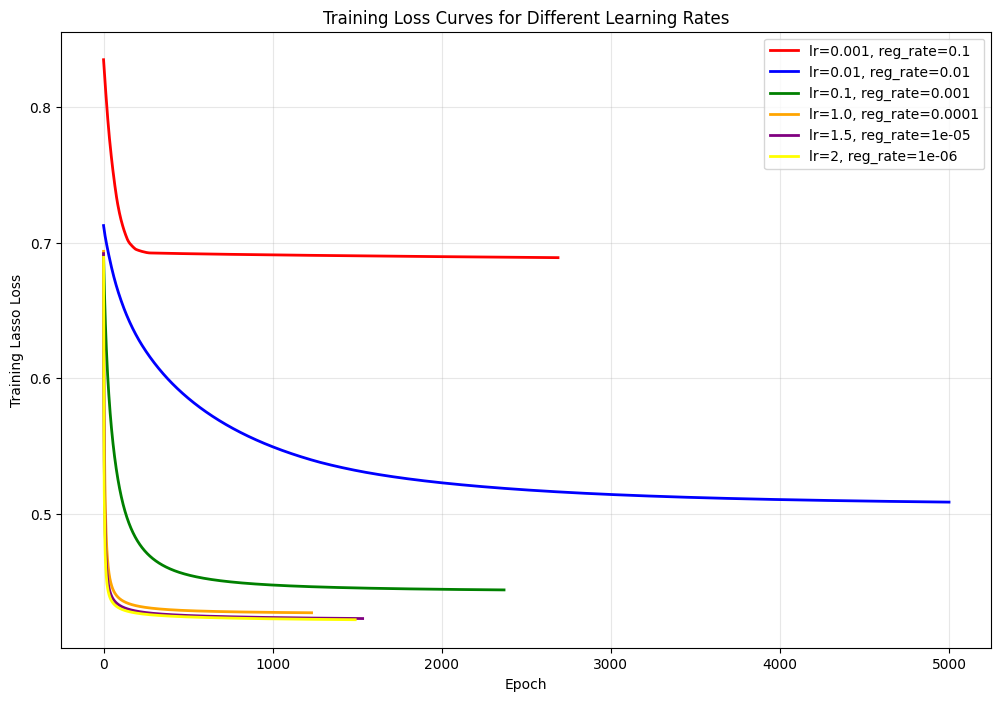

In [10]:
# Your code goes here
# Set random seed for reproducibility
np.random.seed(42)

reg_rates =      [0.1,   0.01,  0.001, 0.0001, 1e-5,  1e-6]
learning_rates = [0.001, 0.01, 0.1,  1.0,   1.5,   2]

results = []

w_list = []
train_losses_list = []
converged_rates = []

for i, (reg_rate, lr) in enumerate(zip(reg_rates, learning_rates)):
    print(f"Learning rate: {lr},   Regularization rate: {reg_rate}")
    
    w, losses = lasso_logistic_regression(x_train.to_numpy(), y_train.to_numpy(), gamma=lr, lmbda=reg_rate, epochs=5000, epsilon_loss=10e-7)
    
    # Check if converged (no NaN values)
    if not np.any(np.isnan(w)) and not np.any(np.isnan(losses)):
        w_list.append(w)
        train_losses_list.append(losses)
        converged_rates.append((reg_rate,lr))

        # Calculate training accuracy
        y_train_pred = sigmoid(x_train.to_numpy() @ w)
        y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
        train_accuracy = np.mean(y_train_pred_binary.flatten() == y_train.to_numpy())
        
        # Calculate validation accuracy
        y_val_pred = sigmoid(x_val.to_numpy() @ w)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        val_accuracy = np.mean(y_val_pred_binary.flatten() == y_val.to_numpy())

        # Store results
        results.append({
            'lambda': reg_rate,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'final_train_loss': losses[-1],
            'converge_epoch': len(losses)
        })

# Create and display results table
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

#Plot learning curves
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

for i, (rates, losses) in enumerate(zip(converged_rates, train_losses_list)):
    plt.plot(losses, color=colors[i % len(colors)], label=f'lr={rates[1]}, reg_rate={rates[0]}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training Lasso Loss')
plt.title('Training Loss Curves for Different Learning Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🚧 Visualize and analyze  λ 's impact on training and validation accuracy
Now, use the results from your experiments to visualize how model performance changes with the regularization strength. Plot both the training accuracy and validation accuracy of your L1 regularized logistic regression model as a function of $\lambda$.
* Use a logarithmic scale for the x-axis to represent $\lambda$. Each tick mark on the x-axis should correspond to an integar $i$ and be labeled as $10^{i}$. This helps you clearly see performance trends across multiple orders of magnitude of $\lambda$.  

* Plot the two curves in the same figure, one for training accuracy and one for validation accuracy, using different colors for clarity.
* Include a legend to indicate which curve corresponds to which accuracy measure, and label the axis clearly.

Your final plot should make it easy to compare how regularization affects training vs. validation performance.

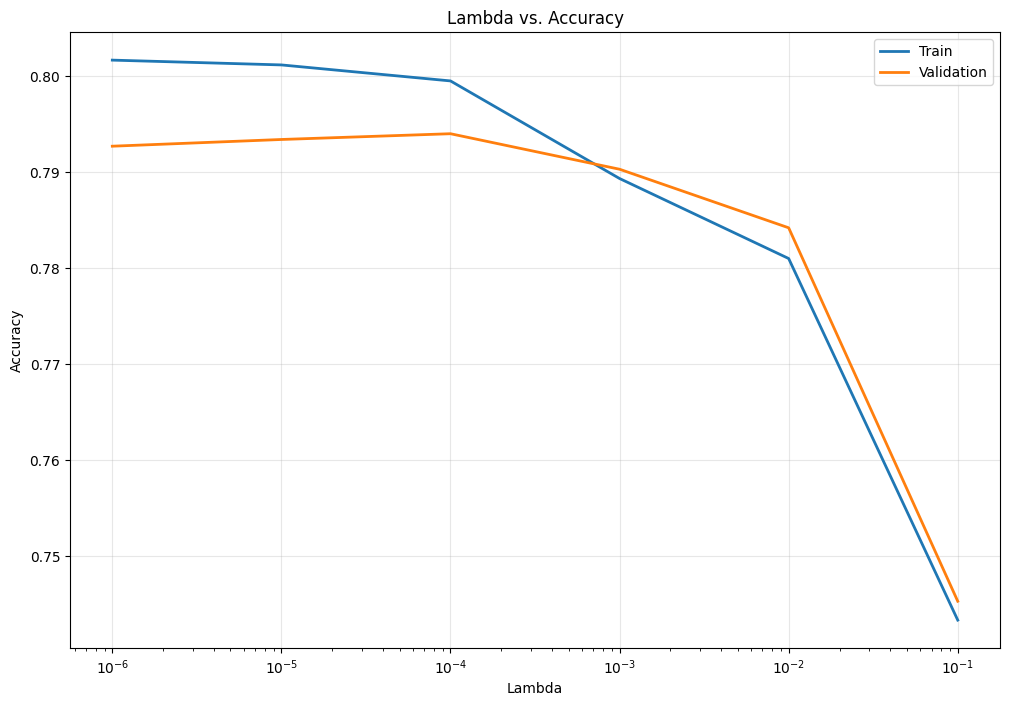

In [11]:
# Your code goes here
#Plot learning curves
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

train_acc = results_df['train_acc'].to_numpy()
val_acc = results_df['val_acc'].to_numpy()

reg_rates_arr = np.array(reg_rates)

plt.plot(reg_rates_arr, train_acc, label='Train', linewidth=2)

plt.plot(reg_rates_arr, val_acc, label='Validation', linewidth=2)

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Lambda vs. Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## ✍️Question
Based on your results, answer the following questions.

a. For L1 LR, which $\lambda$ value leads to the best training and validatoin accuracy respectively? If you were to select a model for deployment, which
$\lambda$ would you choose, and why?

b. What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Explain this trend and provide an intuitive reasoning for why it occurs.

c. Comparing L1 and L2 regularized logistic regression, which one is more sensitive to the choice of the regularization parameter? An algorithm is considered sensitive if its performance or learned parameters change significantly when the regularization strength changes.
Since your experiments may have used a smaller range of $\lambda$ values for L1 regularization due to convergence concerns, you may use an off-the-shelf implementation (e.g., from scikit-learn) to explore this comparison more fully. Reflect on the differences you observe (or expect to observe) between L1 and L2 in terms of their sensitivity, and explain why.


a.- **A lambda=10e-4 leads to the best validation accuracy, and a lambda=10e-6 leads to the best training accuracy. I would select a lambda of 10e-4 since it has the best validation accuracy.**

b.- **We see a similar trend as we observed in L2 ridge regression. As we increase lambda  our accuracy on both train and validation data tends to decrease. This is occuring since we are increasing the loss based on the magnitude of the weights, thus the optimal solution with high lambda values, requires a weight vector where a lot of values will be close to zero. This in turn affects how expressive our model can be leading to low accuracy on both train and validation data.**

c.- **In theory L2 regularized logistic regression should be more sensitive to the choice of regularization since its value is being multiplied by each weight squared, thus its impact on the loss should be greater. However the plots show that both behave very similar with a similar set of lambdas and gammas. What we do see is that for the case of L1 regularization the best validation accuracy is not achieved at the smalled value of gamma, while with L2 regularization the lowest value of gamma is the one that provides the best training and validation accuracy. It's a tiny difference but it implies that L1 regularization can still perform well with higher values of gamma than L2.**

## 🚧 Examine the impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [12]:
# Your code goes here
reg_rate_feature_map = {}

# Get feature names (excluding bias)
feature_names = x_train.columns[1:].tolist()  # Skip bias column

for w, reg_rate in zip(w_list, reg_rates):
    # Get weights excluding bias (first element)
    weights_no_bias = w[1:].flatten()
    
    # Get absolute values for ranking
    abs_weights = np.abs(weights_no_bias)
    
    # Get indices of top 5 features by weight magnitude
    top_indices = np.argsort(abs_weights)[::-1][:5]
    
    # Create list of (feature_name, weight) tuples for top 5
    top_features = []
    for idx in top_indices:
        feature_name = feature_names[idx]
        weight_value = weights_no_bias[idx]
        top_features.append(f"{feature_name}, {weight_value:.4f}")
    
    # Store in dictionary
    reg_rate_feature_map[f"λ = {reg_rate}"] = top_features

# Split into three tables (2 columns each)
lambda_cols = list(reg_rate_feature_map.keys())
n_cols_per_table = 2

# Create first table (first 2 lambda values)
first_cols = lambda_cols[:n_cols_per_table]
reg_rate_feature_df1 = pd.DataFrame({col: reg_rate_feature_map[col] for col in first_cols})
reg_rate_feature_df1.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df1) + 1))

# Create second table (next 2 lambda values)
second_cols = lambda_cols[n_cols_per_table:2*n_cols_per_table]
reg_rate_feature_df2 = pd.DataFrame({col: reg_rate_feature_map[col] for col in second_cols})
reg_rate_feature_df2.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df2) + 1))

# Create third table (remaining 2 lambda values)
third_cols = lambda_cols[2*n_cols_per_table:]
reg_rate_feature_df3 = pd.DataFrame({col: reg_rate_feature_map[col] for col in third_cols})
reg_rate_feature_df3.insert(loc=0, column="Rank", value=np.arange(1, len(reg_rate_feature_df3) + 1))

# Display results
print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 1)")
print("="*80)
print(reg_rate_feature_df1.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 2)")
print("="*80)
print(reg_rate_feature_df2.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("Feature weights ranked by regularization rates (Part 3)")
print("="*80)
print(reg_rate_feature_df3.to_string(index=False))
print("="*80)


Feature weights ranked by regularization rates (Part 1)
 Rank                           λ = 0.1                          λ = 0.01
    1            Vehicle_Damage, 0.0805       Previously_Insured, -1.6537
    2       Previously_Insured, -0.0761            Vehicle_Damage, 1.2317
    3  Policy_Sales_Channel_159, 0.0000 Policy_Sales_Channel_152, -0.4726
    4 Policy_Sales_Channel_160, -0.0000            Vehicle_Age_1, -0.4657
    5  Policy_Sales_Channel_163, 0.0000                    dummy, -0.1878

Feature weights ranked by regularization rates (Part 2)
 Rank                         λ = 0.001                        λ = 0.0001
    1       Previously_Insured, -2.5996       Previously_Insured, -3.2040
    2            Vehicle_Damage, 2.0590            Vehicle_Damage, 2.2251
    3 Policy_Sales_Channel_160, -0.9350 Policy_Sales_Channel_160, -1.8108
    4 Policy_Sales_Channel_152, -0.7357                    dummy, -0.9833
    5            Vehicle_Age_1, -0.6384 Policy_Sales_Channel_152, -0.905

##✍️Question

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


1.- **The top-2 features are the same for all lambda values except lambda=0.1. The rest of the features vary between all values of lambda.**

2.- **As the lambda value decreases so does the weight of the top features. For example the Vehicle_Damage feature has a value of 0.0805 for a lambda=0.1 and goes up to 2.26 with a lambda=1e-6**

3.- **The differences are related to how as lambda increases we penalize more and more the magnitude of the weights. So for small lambda values we observe large weights for all features and for small ones we observe very small weight values for all features.**

**Regarding the difference in the top-5 features its related to how the optimization process changes for different lambdas, so as lambda increases and we limit the expressiveness of the weight vector, the algorithm has to give more importance to other features to makeup for the loss increase. That's why the top-5 features vary.**

4.- **Comparing both L1 and L2 regularization, I noticed that the order of the top-5 features is the same. That is for the same lambda value, both L1 and L2 give the same top-5 features. This is expected as both regularization techniques are penalizing the same thing, the magnitude of the weights.** 

**On the other hand, their values do change slightly, with L1 regularization having in average slightly higher weight values than L2 regularization. It's a very small difference but it is related to the fact that L1 regularization does not penalize the weight magnitude so heavily as L2 regularization. Thus sames values of lambda lead to higher weights in L1 when compared to L2.**

## 🚧 Examine the impact on sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [13]:
# Your code goes here
sparsity_results = []

for w, reg_rate in zip(w_list, reg_rates):
    # Get weights excluding bias (first element)
    weights_no_bias = w[1:].flatten()

    # Count weights that are approximately zero (≤ 10^-6)
    sparse_count = np.sum(np.abs(weights_no_bias) <= 10e-6)
    total_features = len(weights_no_bias)

    sparsity_results.append({
        'lambda': reg_rate,
        'Sparse Features': sparse_count,
        'Total Features': total_features,
        'Sparsity Percentage': (sparse_count / total_features) * 100
    })
    
    print(f"λ = {reg_rate}: {sparse_count}/{total_features} features are sparse ({(sparse_count/total_features)*100:.1f}%)")

λ = 0.1: 195/197 features are sparse (99.0%)
λ = 0.01: 189/197 features are sparse (95.9%)
λ = 0.001: 168/197 features are sparse (85.3%)
λ = 0.0001: 113/197 features are sparse (57.4%)
λ = 1e-05: 60/197 features are sparse (30.5%)
λ = 1e-06: 9/197 features are sparse (4.6%)


## ✍️Question

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


1.- **The trend I observe is that as lambda increases the sparsity of the weights also increases. If we further increase lambda I would expect all weights to go to zero.**

2.- **The biggest difference between the L1 and L2 regularization is that L1 regularization has really high sparsity as lambda increases. Where L2 regularization has barely any sparsity. This occurs because of the thresholding operation that L1 regularization uses, this thresholding is specifically setting weights that are smaller than lambda*gamma directly to zero. This is what is creating such sparse weight matrices.**

# Part 3. (15 pts) Impact of Noise in Training Data
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data (IA2-train-noisy.csv).

## 🚧 Experiment L1 and L2 Logistic Regression on Noisy Training data.
This experiment follows the same structure as Parts 1 and 2, so you can reuse your previous code—just provide the noisy training data (IA2-train-noisy.csv) as input.
You may also use an off-the-shelf implementation such as sklearn.linear_model.LogisticRegression, which will typically be more efficient than your custom version.
If you choose to use scikit-learn:
* Set the penalty argument to 'l1' or 'l2'.

* Use the 'liblinear' or 'saga' solver (required for L1).

* Remember that scikit-learn’s regularization parameter is defined as C=$\frac{1}{\lambda}$, so smaller 𝐶 values correspond to stronger regularization.

For each regularization type:

* Train the model for each λ value as specified in each part. (For L1, you can exclude $\lambda=0.1$, which can be difficult to converge)

* Record the accuracies on the noisy training data and the clean validation data for each $\lambda$ value.

* Plot both accuracies as functions of λ on a logarithmic x-axis, using distinct colors and a clear legend.

* Both curves (training and validation) should appear on the same figure for easy comparison.

Your plots should clearly illustrate how model performance changes with different regularization strengths under noisy conditions.

In [14]:
def preprocess_sklearn(train_df, df):
    """
    Preprocess data for sklearn models (no bias column needed)
    """
    train_df = train_df.copy()
    df = df.copy()

    # Normalize numerical columns
    for col_name in ["Age", "Annual_Premium", "Vintage"]:
        mu = train_df[col_name].mean()
        sigma = train_df[col_name].std()
        
        df[col_name] = (df[col_name] - mu) / sigma
    
    # Return features and target (if exists)
    if 'Response' in df.columns:
        return df.drop(columns=['Response']), df['Response']
    else:
        return df

In [15]:
# Your code goes here
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

x_train, y_train = preprocess_sklearn(train_df, train_df)
x_val, y_val = preprocess_sklearn(train_df, val_df)
x_noisy_train, y_noisy_train = preprocess_sklearn(noisy_train_df, noisy_train_df)

# Lambda values for L2 (same as Part 1)
lambdas_l2 = [10**-i for i in range(0, 6)]  # [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# Lambda values for L1 (exclude 0.1 as suggested)
lambdas_l1 = [10**-i for i in range(1, 7)]  # [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

# Convert to C values (C = 1/lambda)
C_values_l2 = [1/lmbda for lmbda in lambdas_l2]
C_values_l1 = [1/lmbda for lmbda in lambdas_l1]

results_l2_noisy = []
results_l1_noisy = []

print("="*80)
print("TRAINING L2 (RIDGE) LOGISTIC REGRESSION ON NOISY DATA")
print("="*80)

for lmbda, C in zip(lambdas_l2, C_values_l2):
    print(f"Training L2 with λ = {lmbda:.1e} (C = {C:.1e})")
    
    # Train L2 regularized logistic regression
    model_l2 = LogisticRegression(
        penalty='l2',
        C=C,
        solver='liblinear',
        max_iter=5000,
        random_state=42
    )
    
    model_l2.fit(x_noisy_train.to_numpy(), y_noisy_train.to_numpy())
    
    # Calculate training accuracy (on noisy data)
    train_acc = model_l2.score(x_noisy_train.to_numpy(), y_noisy_train.to_numpy())
    
    # Calculate validation accuracy (on clean data)
    val_acc = model_l2.score(x_val.to_numpy(), y_val.to_numpy())
    
    results_l2_noisy.append({
        'lambda': lmbda,
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc
    })
    
    print(f"  Train Acc (noisy): {train_acc:.4f}, Val Acc (clean): {val_acc:.4f}\n")

print("\n" + "="*80)
print("TRAINING L1 (LASSO) LOGISTIC REGRESSION ON NOISY DATA")
print("="*80)

for lmbda, C in zip(lambdas_l1, C_values_l1):
    print(f"Training L1 with λ = {lmbda:.1e} (C = {C:.1e})")
    
    # Train L1 regularized logistic regression
    model_l1 = LogisticRegression(
        penalty='l1',
        C=C,
        solver='saga',  # 'saga' or 'liblinear' for L1
        max_iter=5000,
        random_state=42
    )
    
    model_l1.fit(x_noisy_train.to_numpy(), y_noisy_train.to_numpy())
    
    # Calculate training accuracy (on noisy data)
    train_acc = model_l1.score(x_noisy_train.to_numpy(), y_noisy_train.to_numpy())
    
    # Calculate validation accuracy (on clean data)
    val_acc = model_l1.score(x_val.to_numpy(), y_val.to_numpy())
    
    results_l1_noisy.append({
        'lambda': lmbda,
        'C': C,
        'train_acc': train_acc,
        'val_acc': val_acc
    })
    
    print(f"  Train Acc (noisy): {train_acc:.4f}, Val Acc (clean): {val_acc:.4f}\n")

# Create DataFrames
results_l2_noisy_df = pd.DataFrame(results_l2_noisy)
results_l1_noisy_df = pd.DataFrame(results_l1_noisy)

TRAINING L2 (RIDGE) LOGISTIC REGRESSION ON NOISY DATA
Training L2 with λ = 1.0e+00 (C = 1.0e+00)
  Train Acc (noisy): 0.6235, Val Acc (clean): 0.7792

Training L2 with λ = 1.0e-01 (C = 1.0e+01)
  Train Acc (noisy): 0.6245, Val Acc (clean): 0.7768

Training L2 with λ = 1.0e-02 (C = 1.0e+02)
  Train Acc (noisy): 0.6250, Val Acc (clean): 0.7766

Training L2 with λ = 1.0e-03 (C = 1.0e+03)
  Train Acc (noisy): 0.6247, Val Acc (clean): 0.7762

Training L2 with λ = 1.0e-04 (C = 1.0e+04)
  Train Acc (noisy): 0.6247, Val Acc (clean): 0.7759

Training L2 with λ = 1.0e-05 (C = 1.0e+05)
  Train Acc (noisy): 0.6248, Val Acc (clean): 0.7761


TRAINING L1 (LASSO) LOGISTIC REGRESSION ON NOISY DATA
Training L1 with λ = 1.0e-01 (C = 1.0e+01)
  Train Acc (noisy): 0.6245, Val Acc (clean): 0.7773

Training L1 with λ = 1.0e-02 (C = 1.0e+02)
  Train Acc (noisy): 0.6242, Val Acc (clean): 0.7770

Training L1 with λ = 1.0e-03 (C = 1.0e+03)
  Train Acc (noisy): 0.6245, Val Acc (clean): 0.7768

Training L1 with λ


L2 REGULARIZATION RESULTS (NOISY TRAINING DATA)
 lambda        C  train_acc  val_acc
1.00000      1.0   0.623500   0.7792
0.10000     10.0   0.624500   0.7768
0.01000    100.0   0.625000   0.7766
0.00100   1000.0   0.624667   0.7762
0.00010  10000.0   0.624667   0.7759
0.00001 100000.0   0.624833   0.7761

L1 REGULARIZATION RESULTS (NOISY TRAINING DATA)
  lambda         C  train_acc  val_acc
0.100000      10.0   0.624500   0.7773
0.010000     100.0   0.624167   0.7770
0.001000    1000.0   0.624500   0.7768
0.000100   10000.0   0.624500   0.7767
0.000010  100000.0   0.624500   0.7767
0.000001 1000000.0   0.624500   0.7767


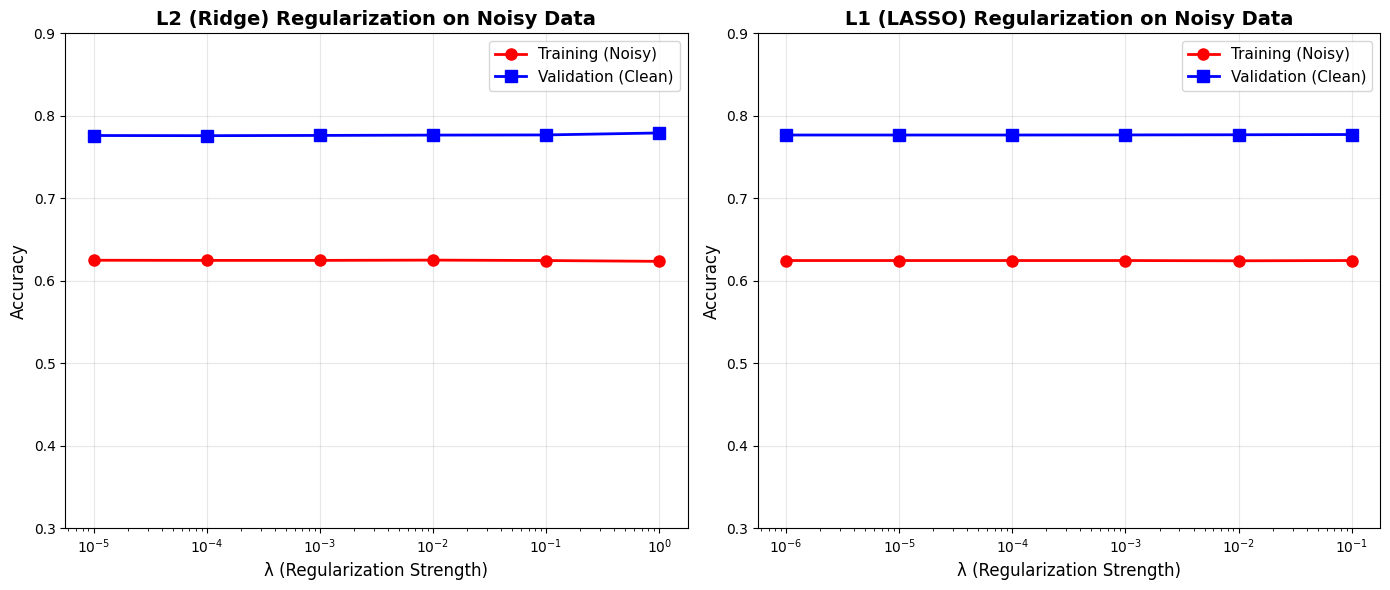

In [16]:
# Display results tables
print("\n" + "="*80)
print("L2 REGULARIZATION RESULTS (NOISY TRAINING DATA)")
print("="*80)
print(results_l2_noisy_df.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("L1 REGULARIZATION RESULTS (NOISY TRAINING DATA)")
print("="*80)
print(results_l1_noisy_df.to_string(index=False))
print("="*80)

# # Plot L2 results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(results_l2_noisy_df['lambda'], 
         results_l2_noisy_df['train_acc'], 
         'o-', color='red', linewidth=2, markersize=8, label='Training (Noisy)')
plt.plot(results_l2_noisy_df['lambda'], 
         results_l2_noisy_df['val_acc'], 
         's-', color='blue', linewidth=2, markersize=8, label='Validation (Clean)')
plt.xscale('log')
plt.xlabel('λ (Regularization Strength)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('L2 (Ridge) Regularization on Noisy Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.3, 0.9])  # Adjust based on your results

# # Plot L1 results
plt.subplot(1, 2, 2)
plt.plot(results_l1_noisy_df['lambda'], 
         results_l1_noisy_df['train_acc'], 
         'o-', color='red', linewidth=2, markersize=8, label='Training (Noisy)')
plt.plot(results_l1_noisy_df['lambda'], 
         results_l1_noisy_df['val_acc'], 
         's-', color='blue', linewidth=2, markersize=8, label='Validation (Clean)')
plt.xscale('log')
plt.xlabel('λ (Regularization Strength)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('L1 (LASSO) Regularization on Noisy Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.3, 0.9])  # Adjust based on your results

plt.tight_layout()
plt.show()

## ✍️Question
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression have substantially reduced training accuracies, but only a small drop in validation accuracy.

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which limits the model's ability to overfit to the noise.
2. This is due to the simplicity of the model, which prevents overfitting even without regularization.

Which explanation better accounts for your results, and why? Support your reasoning using evidence from your plots (e.g., how accuracy changes with
λ, or differences between L1 and L2).

Design a brief experiment to figure which explanation fits in this particular case. between these two explanations. Describe what you would vary, what you would keep fixed, and what outcome would support each hypothesis. (You only need to describe the experiment, not run it.)

**Between the 2 explanations the second one seems to be the one that makes the most sense. The main reason for this is that in the above plot, the gap between Training and Validation data remains the same across lambda values, suggesting regularization has no effect on the model accuracy. This implies that no matter how much regularization we apply, the model is just not capable of better fitting to the training data.**

**For the experiment design, we already tested Logistic Regression across different lambdas, this alone suggest regularization is having no effect, and that model complexity is the issue. What I would test next I would do the following:**

**Vary model structure, try logistic vs. SVM vs. Neural Network. Train a model for each lambda value and model combination.**

**If any of the other models is able to obtain higher training than validation accuracy on the noisy data, then we can conclude that the issue was that logistic regression had not enough complexity to fit the training data.**



# Part 4. (10 pts) In-class competition
We will host a in-class competition using the IA2 data. To participate in this competition, use the following link:
https://www.kaggle.com/competitions/ai534-ia2-25

**Model restriction.** For this competition, you are required to use logistic regression models. You are welcome to use off-the-shelf implementations, such as sklearn.linear_model.LogisticRegression.

**Exploration encouraged.** To improve your model's performance, you may:

* Perform feature engineering (create, modify, or combine features).
* Manipulate the data (upsample or downsample the training set)
* Experiment with hyperparameter tuning.
* Try different regularization methods (e.g., L1, L2).


**Team work.** You should continue working in the same team for this competition. The training and validation data provided on the kaggle site are the same as the IA2 assignment.

**Evaluation** To participate, you will apply your trained/tuned model to the test data provided on kaggle (which does not contian the response column), and submit prediction files to be scored, based on prediction accuracy.

There are two parts to the score you will see on kaggle. The performance reported on the public leaderboard and a score reported on the private leaderboard. The public leader board scores are visible through out the competition and you can use it as an external validation to help you refine your model design and tune the model. The private leader board scores are evaluated using a separate set of test data as the final performance evaluation and will be released only after the competition is closed.

**Points and bonus points.** You will get the full 10 points if you

* participate in the competition (successful submissions)

* achieve non-trivial performance (outperform some simple baseline)

* complete the report on the competition below.

You will get 3 **nonus points** if your team scored top 3 on the private leader board, or entered the largest number of unique submissions (unique sores).

No late submission. The competition will be closed at 11:59 pm of the due date.

In [17]:
def create_engineered_features(df):
    """
    Create new features from existing ones
    """
    df_new = df.copy()
    
    # Age-based features
    df_new['Age_squared'] = df_new['Age'] ** 2
    df_new['Age_bins'] = pd.cut(df_new['Age'], bins=5, labels=False)
    
    # Premium-based features
    df_new['Premium_per_age'] = df_new['Annual_Premium'] / (df_new['Age'] + 1)
    df_new['Premium_log'] = np.log1p(df_new['Annual_Premium'])
    
    # Interaction features
    df_new['Age_Premium_interaction'] = df_new['Age'] * df_new['Annual_Premium']
    df_new['Age_Vintage_interaction'] = df_new['Age'] * df_new['Vintage']
    
    # Categorical combinations
    if 'Gender' in df_new.columns and 'Vehicle_Age' in df_new.columns:
        df_new['Gender_VehicleAge'] = df_new['Gender'].astype(str) + '_' + df_new['Vehicle_Age'].astype(str)
    
    return df_new

In [18]:
from sklearn.linear_model import LogisticRegression

def train_with_feature_selection(X_train, y_train, X_val, y_val, n_features=20):
    """
    Select top features and train model
    """
    print("\n" + "="*80)
    print("STRATEGY: FEATURE SELECTION")
    print("="*80)
    
    # Train a model to get feature importances
    temp_model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=5000, random_state=42)
    temp_model.fit(X_train, y_train)
    
    # Get feature importances
    feature_importance = np.abs(temp_model.coef_[0])
    top_features_idx = np.argsort(feature_importance)[::-1][:n_features]
    top_features = X_train.columns[top_features_idx].tolist()
    
    print(f"Top {n_features} features:")
    for i, (feat, imp) in enumerate(zip(top_features, feature_importance[top_features_idx]), 1):
        print(f"  {i:2d}. {feat:30s}: {imp:.4f}")
    
    # Train on selected features
    X_train_selected = X_train[top_features]
    X_val_selected = X_val[top_features]
    
    # Try different models
    best_val_acc = 0
    best_model = None
    best_C = None
    
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        model = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=5000, random_state=42)
        model.fit(X_train_selected, y_train)
        val_acc = model.score(X_val_selected, y_val)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_C = C
    
    print(f"\nBest C: {best_C}")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")
    
    return best_model, top_features

In [19]:
from sklearn.linear_model import LogisticRegression

def train_default(X_train, y_train, X_val, y_val):
    """
    Select top features and train model
    """
    print("\n" + "="*80)
    print("STRATEGY: DEFAULT")
    print("="*80)
    
    # Try different models
    best_val_acc = 0
    best_model = None
    best_C = None
    
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        model = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=5000, random_state=42)
        model.fit(X_train, y_train)
        val_acc = model.score(X_val, y_val)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_C = C
    
    print(f"\nBest C: {best_C}")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")
    
    return best_model

In [20]:
from sklearn.model_selection import GridSearchCV

def optimize_hyperparameters(X_train, y_train, X_val, y_val):
    """
    Comprehensive hyperparameter tuning
    """
    print("\n" + "="*80)
    print("STRATEGY: Hyper param tuning")
    print("="*80)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
    }
    
    logistic = LogisticRegression(random_state=42, max_iter=5000)
    
    # Use stratified k-fold for better validation
    grid_search = GridSearchCV(
        logistic, 
        param_grid, 
        cv=5, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Validate on holdout set
    val_score = grid_search.best_estimator_.score(X_val, y_val)
    print(f"Validation score: {val_score:.4f}")
    
    return grid_search.best_estimator_

In [21]:
def feature_engineering(train_df, val_df, test_df):
    """
    Combine multiple strategies
    """
    print("="*80)
    print("COMPREHENSIVE APPROACH")
    print("="*80)
    
    # 1. Feature Engineering
    train_eng = create_engineered_features(train_df)
    val_eng = create_engineered_features(val_df)
    test_eng = create_engineered_features(test_df)
    
    x_train, y_train = preprocess_sklearn(train_eng, train_eng)
    x_val, y_val = preprocess_sklearn(val_eng, val_eng)
    x_test = preprocess_sklearn(train_eng, test_eng)
    
    return x_train, y_train, x_val, y_val, x_test

In [22]:
def generate_submission(model, X_test, test_df, filename='submission.csv', use_features=None):
    """
    Generate Kaggle submission file
    """
    if use_features is not None:
        X_test = X_test[use_features]
    
    predictions = model.predict(X_test)
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'id': test_df.index,  # Assuming index is the ID
        'Response': predictions
    })
    
    submission.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")
    print(f"Prediction distribution:\n{pd.Series(predictions).value_counts()}")
    
    return submission

In [23]:
import warnings
warnings.filterwarnings('ignore')

train_path = './kaggle/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = './kaggle/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
test_path = './kaggle/IA2-test-small-v2-X.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

x_train, y_train = preprocess_sklearn(train_df, train_df)
x_val, y_val = preprocess_sklearn(train_df, val_df)
x_test = preprocess_sklearn(train_df, test_df)

best_model_def = train_default(x_train, y_train, x_val, y_val)

submission1 = generate_submission(best_model_def, x_test, test_df, 'submission_default.csv')

best_model_fs, top_features = train_with_feature_selection(x_train, y_train, x_val, y_val, n_features=25)

submission2 = generate_submission(best_model_fs, x_test, test_df, 'submission_feature_selection.csv', use_features=top_features)

#Feature engineering
x_train_eng, y_train_eng, x_val_eng, y_val_eng, x_test_eng = feature_engineering(train_df, val_df, test_df)
best_model_feat = train_default(x_train_eng, y_train_eng, x_val_eng, y_val_eng)

submission3 = generate_submission(best_model_feat, x_test_eng, test_df, 'submission_feature_engineering.csv')

#Hyperparameter tuning
best_model_tuning = optimize_hyperparameters(x_train, y_train, x_val, y_val)

submission4 = generate_submission(best_model_tuning, x_test, test_df, 'submission_hyper_tuning.csv')





Train shape: (6000, 198)
Val shape: (10000, 198)
Test shape: (25000, 197)

STRATEGY: DEFAULT

Best C: 1
Best Val Accuracy: 0.7934
Submission saved to submission_default.csv
Prediction distribution:
1    15734
0     9266
Name: count, dtype: int64

STRATEGY: FEATURE SELECTION
Top 25 features:
   1. Previously_Insured            : 2.9301
   2. Vehicle_Damage                : 1.9462
   3. Policy_Sales_Channel_160      : 1.5034
   4. Policy_Sales_Channel_152      : 0.9211
   5. dummy                         : 0.4552
   6. Vehicle_Age_1                 : 0.3757
   7. Age                           : 0.3337
   8. Policy_Sales_Channel_26       : 0.3013
   9. Region_Code_3                 : 0.2487
  10. Policy_Sales_Channel_124      : 0.1749
  11. Region_Code_50                : 0.1438
  12. Region_Code_28                : 0.1187
  13. Policy_Sales_Channel_157      : 0.0571
  14. Vintage                       : 0.0447
  15. Annual_Premium                : 0.0419
  16. Vehicle_Age_0              

##✍️ Report on the Kaggle competition
1. Team name: Manuel Agraz Vallejo
2. Exploration Summary: Brief describe the approches you tried.

**I tried three approaches:**


**1.- First approach is simple L2 logistic regression with feature normalization. This achieved the second best performance of my attempts.**

**2.-Second approach is Feature selection. I first trained a model using logistic regression, then used the weights to determine which features are the most important based on weight magnitude. Next took the top 25 features and used those to train a model. It achieved similar performance to L2 logistic regression without features selection.**

**3.-Thirdly I tried some feature engineering by creating some extra features based on the age, premium and interaction based features. This gave me the worst performance of all attempts.**

**4.-Finally I tried using Grid Search from the scikit learn library. This form of parameter tuning took a long time and only achieved marginally better performance than simple l2 logistic regression. This was my best performer.**

3. Most Impactful Change: Which exploration led to the most performance improvement, and why do you think it helped?

**I can't really establish which one was the best approach since the difference between my 1st and 4th approach was only marginal. But i was able to find the parameters that lead to the best performance using logistic L2: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}. I think it helped mainly to find better parameters, but it only provided marginal performance increase.**

In [24]:
#running this code block will convert this notebook and its outputs into a pdf report.
# !jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/IA2-2024.ipynb  # you might need to change this path to appropriate value to location your copy of the IA0 notebook

# input_html = '/content/gdrive/MyDrive/Colab Notebooks/IA2-2024.html' #you might need to change this path accordingly
# output_pdf = '/content/gdrive/MyDrive/Colab Notebooks/IA2output.pdf' #you might need to change this path or name accordingly

# # Convert HTML to PDF
# pdfkit.from_file(input_html, output_pdf)

# # Download the generated PDF
# files.download(output_pdf)